In [2]:
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D

Using TensorFlow backend.


In [3]:
train_size = 10000
test_size = 3000

train = glob.glob("train/*.jpeg")
test = glob.glob("test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_size]
test = test[:test_size]

piece_symbols = 'prbnkqPRBNKQ'

In [4]:
len(train)

10000

In [5]:
def fen_from_filename(filename):
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

In [6]:
print(fen_from_filename(train[0]))
print(fen_from_filename(train[1]))
print(fen_from_filename(train[2]))

3N4-8-r1r5-3B2kP-3B3b-2K4P-8-8
8-1r6-3P4-K2r1k1n-7P-8-5n2-8
7k-3Q4-8-8-7Q-5KP1-8-8


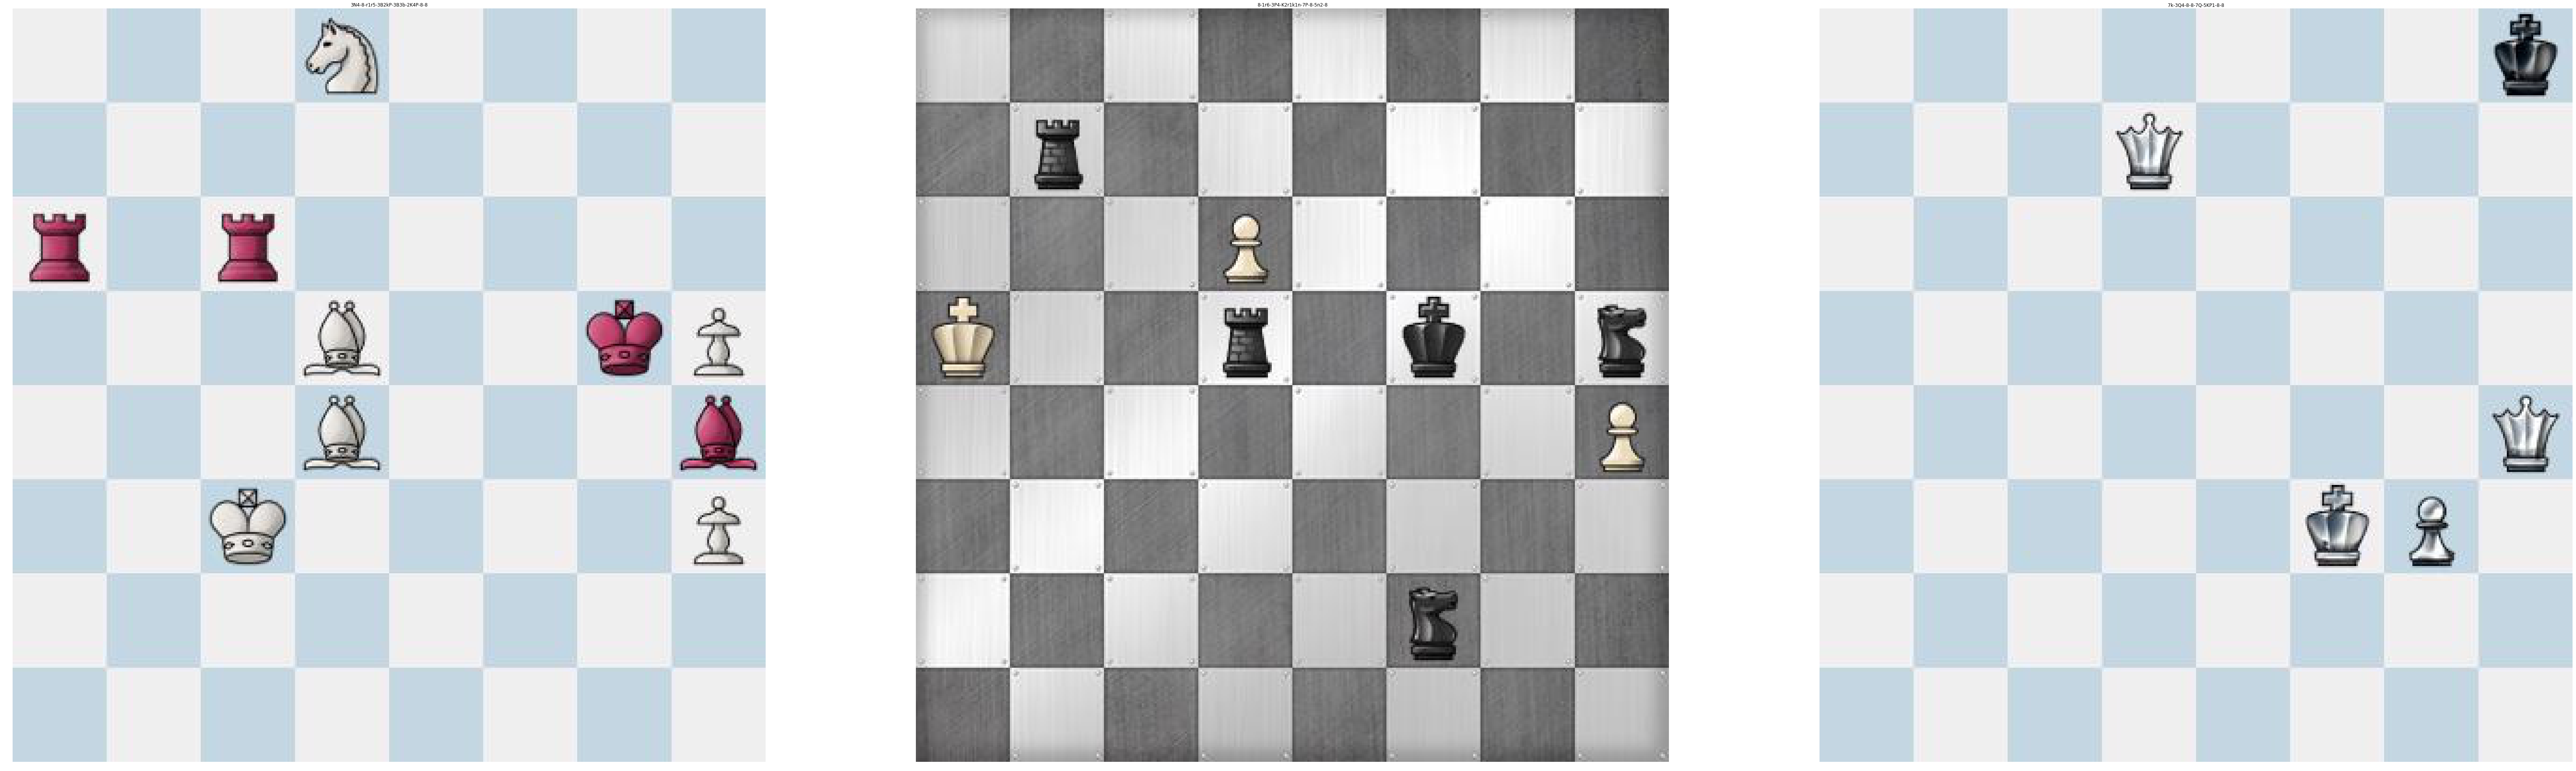

In [7]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(fen_from_filename(train[i]))
    axarr[i].imshow(mpimg.imread(train[i]))
    axarr[i].axis('off')

In [8]:
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

In [9]:
tiles = process_image(train[0])


In [10]:
tiles.shape

(64, 25, 25, 3)

In [11]:
def plot_features(features):
        #features = np.reshape(features,(features.shape[1],features.shape[2],features.shape[3]))
        n_features = features.shape[0]
        n_cols = 8
        n_rows = (n_features// n_cols) + 1
        fig = plt.figure(figsize=(n_cols,n_rows))
        for i in range(features.shape[0]):
            ax1 = fig.add_subplot(n_rows,n_cols,i+1)
            feature = features[i]
            ax1.imshow(feature)
            f = plt.imshow(feature)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
        
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

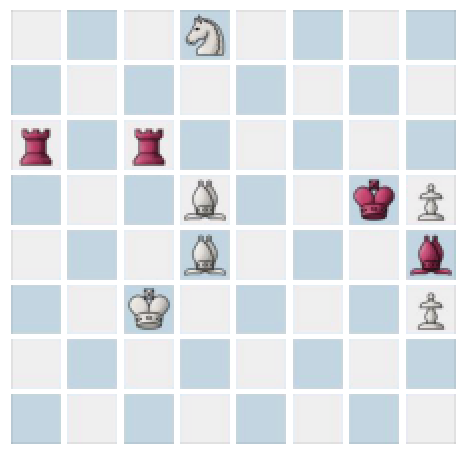

In [12]:
plot_features(tiles)

In [13]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

In [14]:
onehot_from_fen('r7-6R1-6B1-8-7K-8-7k-2n3N1')

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 

In [13]:
def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [14]:
def train_gen(features, labels, batch_size):
    for i, img in enumerate(features):
        y = onehot_from_fen(fen_from_filename(img))
        x = process_image(img)
        yield x, y

In [15]:
def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

In [16]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(25, 25, 3), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3), kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128, kernel_initializer='normal'))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(13, kernel_initializer='normal'))
model.add(Activation('softmax'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 23, 23, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 19, 19, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 11552)             0         
__________

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.fit_generator(train_gen(train, None, 64), steps_per_epoch=train_size)

Epoch 1/1
10000/10000 [==============================] - 1693s 169ms/step - loss: 0.0221 - acc: 0.9944


In [22]:
res = (
  model.predict_generator(pred_gen(test, 64), steps=test_size)
  .argmax(axis=1)
  .reshape(-1, 8, 8)
)

In [23]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_filename(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.99867%


In [24]:
def display_with_predicted_fen(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

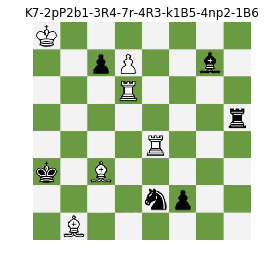

In [25]:
display_with_predicted_fen(test[0])

In [26]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [27]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
